In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [3]:
data_dir = "C:/Users/sullivana6/PycharmProjects/unmasked.ai/fer2013"
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")

In [4]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', valid_tfms)
classes_train = train_ds.classes
valid_ds.classes

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [5]:
torch.cuda.get_device_name(0)

'GeForce GTX 1070 with Max-Q Design'

In [6]:
torch.device('cuda')
device = torch.device('cuda')

In [7]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle = True, num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=128, shuffle = True, num_workers=0)

In [8]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

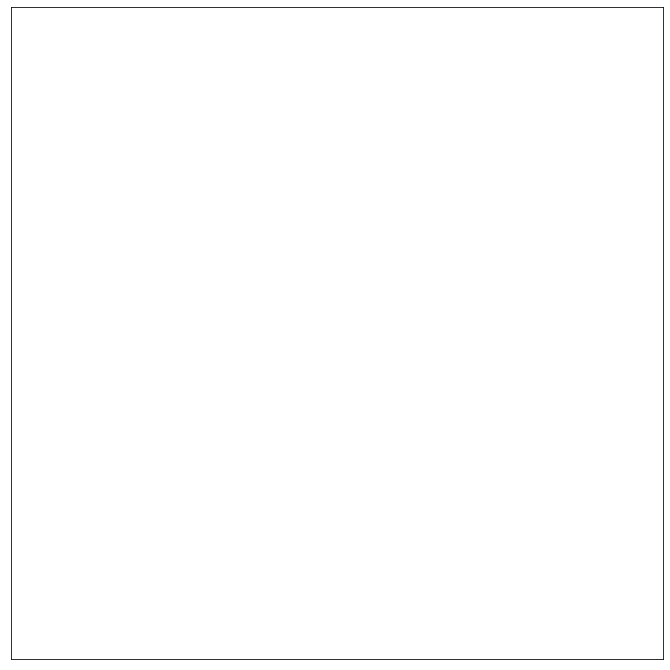

In [13]:
show_batch(train_dl)

In [12]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [17]:
class Emotion_Classifier(ImageClassificationBase):
    
    def __init__(self):
        
        super(Emotion_Classifier,self).__init__()
        
        
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.stn(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out



In [19]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    
    torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_ds)
        train_acc = train_correct.double() / len(train_ds)
        validation_loss =  validation_loss / len(valid_ds)
        val_acc = val_correct.double() / len(valid_ds)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  optimizer, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [24]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.7026004791259766, 'val_acc': 0.31363144516944885}]

In [23]:

model = to_device(ResNet(1, len(classes_train)), device)
batchsize=128
epochs = 50
lr = 0.008
criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(model.parameters(),lr= lr)

fit_one_cycle(epochs, lr, model, train_dl, valid_dl, optmizer)
torch.save(model.state_dict(),'emotion_m-{}-{}-{}.pt'.format(epochs,batchsize,lr))

KeyboardInterrupt: 

In [ ]:
model = ResNet(1, len(classes_train))
model.load_state_dict(torch.load('emotion_m-30-128-0.008.pt'))
model.eval()

In [25]:
%%time
history += fit_one_cycle(50, lr, model, train_dl, valid_dl, 
                        optmizer)

Epoch [0], last_lr: 0.00040, train_loss: 1.6861, val_loss: 1.6037, val_acc: 0.3823
Epoch [1], last_lr: 0.00065, train_loss: 1.5493, val_loss: 1.4983, val_acc: 0.4473
Epoch [2], last_lr: 0.00105, train_loss: 1.5079, val_loss: 1.5741, val_acc: 0.3984
Epoch [3], last_lr: 0.00159, train_loss: 1.4731, val_loss: 1.4559, val_acc: 0.4353
Epoch [4], last_lr: 0.00224, train_loss: 1.4626, val_loss: 1.5365, val_acc: 0.4190
Epoch [5], last_lr: 0.00297, train_loss: 1.4841, val_loss: 1.4147, val_acc: 0.4699
Epoch [6], last_lr: 0.00376, train_loss: 1.4214, val_loss: 1.4478, val_acc: 0.4325
Epoch [7], last_lr: 0.00456, train_loss: 1.3901, val_loss: 1.5119, val_acc: 0.3982
Epoch [8], last_lr: 0.00535, train_loss: 1.3666, val_loss: 1.4124, val_acc: 0.4801
Epoch [9], last_lr: 0.00608, train_loss: 1.2931, val_loss: 1.4371, val_acc: 0.4444
Epoch [10], last_lr: 0.00673, train_loss: 1.2786, val_loss: 1.4122, val_acc: 0.4893
Epoch [11], last_lr: 0.00727, train_loss: 1.2229, val_loss: 1.4450, val_acc: 0.5044
Ep

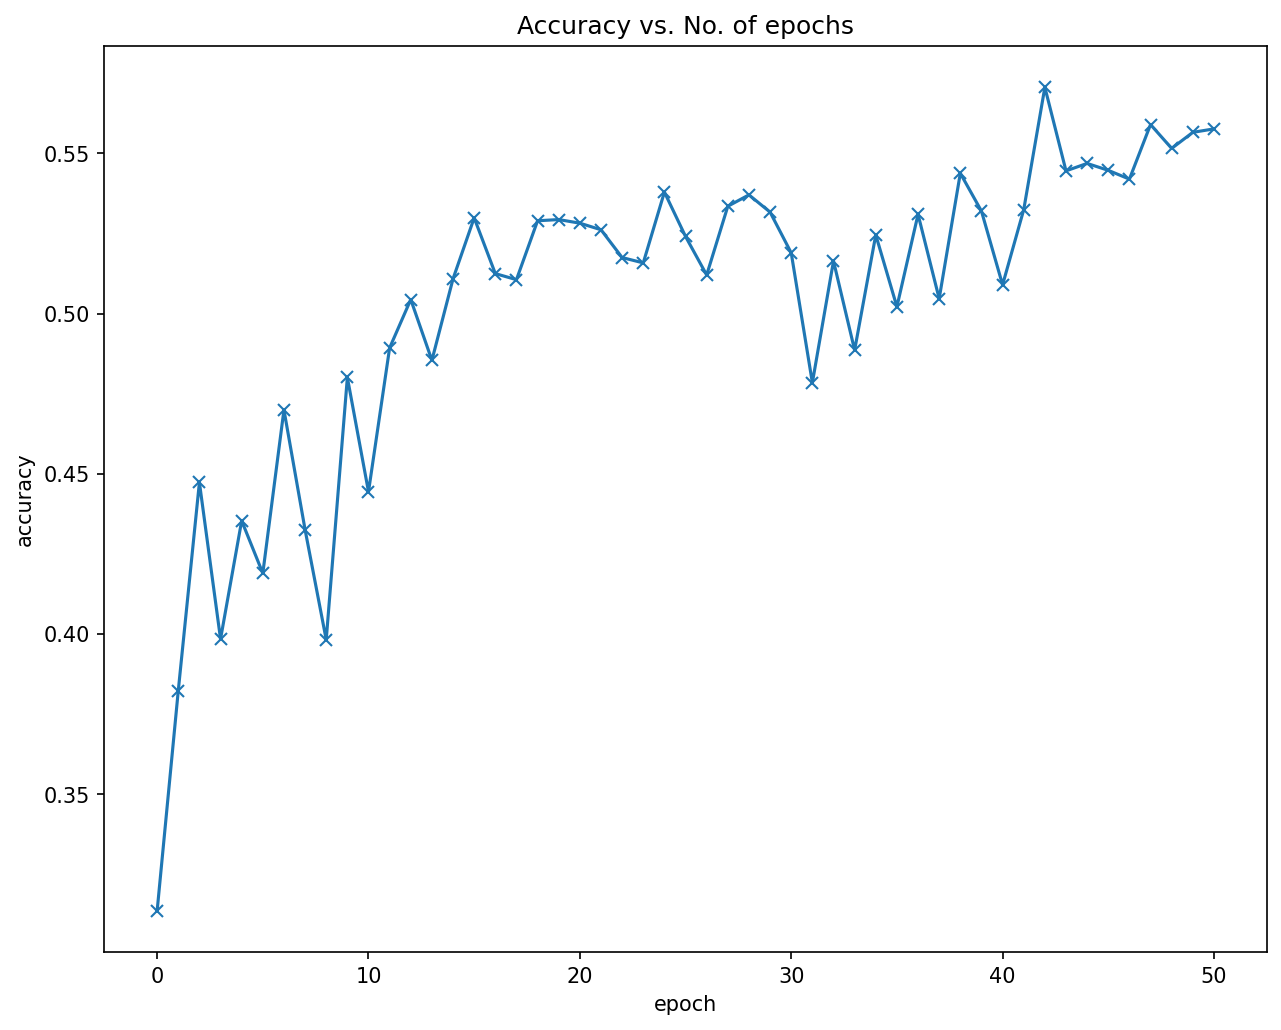

In [31]:

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(10, 8))
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
plot_accuracies(history)

In [79]:
from PIL import Image

input_ts = tt.Compose([tt.Resize(48), tt.ToTensor()])
image = Image.open("face.png")
image = input_ts(image).float()
image = image.unsqueeze(0)  
image.cuda()  
tensor = model(image)
pred = torch.max(tensor, dim=1)[1].tolist()
label = valid_ds.classes[pred[0]]
pred

torch.return_types.max(
values=tensor([1.5388], grad_fn=<MaxBackward0>),
indices=tensor([4]))